In [1]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error


import warnings                               
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("train.csv")

In [3]:
data 

Datetime  ActivePower  AmbientTemperatue  \
0      2018-01-01 06:20:00+00:00    26.212347          28.696304   
1      2018-01-01 06:40:00+00:00    59.632658          29.052567   
2      2018-01-01 06:50:00+00:00    40.889650          28.984758   
3      2018-01-01 10:40:00+00:00    34.398111          30.282058   
4      2018-01-01 12:00:00+00:00    29.797653          29.333519   
...                          ...          ...                ...   
77197  2020-03-15 23:10:00+00:00   272.852287          23.500851   
77198  2020-03-15 23:20:00+00:00   295.675931          23.409183   
77199  2020-03-15 23:30:00+00:00   295.127333          23.336964   
77200  2020-03-15 23:40:00+00:00   342.942216          23.310323   
77201  2020-03-15 23:50:00+00:00   374.401860          23.297918   

       BearingShaftTemperature  Blade1PitchAngle  Blade2PitchAngle  \
0                          NaN               NaN               NaN   
1                          NaN               NaN               NaN   
2                          NaN               NaN               NaN   
3                          NaN               NaN               NaN   
4                          NaN               NaN               NaN   
...                        ...               ...               ...   
77197                43.740629         -0.524250         -0.108540   
77198                43.529209         -0.684376         -0.168882   
77199                43.331115         -0.743521         -0.292512   
77200                43.169442         -0.955621         -0.516466   
77201                43.050359         -0.997635         -0.557849   

       Blade3PitchAngle  GearboxBearingTemperature  GearboxOilTemperature  \
0                   NaN                        NaN                    NaN   
1                   NaN                        NaN                    NaN   
2                   NaN                        NaN                    NaN   
3                   NaN                        NaN                    NaN   
4                   NaN                        NaN                    NaN   
...                 ...                        ...                    ...   
77197         -0.108540                  63.668076              56.801410   
77198         -0.168882                  63.361840              56.551527   
77199         -0.292512                  63.156279              56.393276   
77200         -0.516466                  63.191997              56.273992   
77201         -0.557849                  63.424068              56.175566   

       GeneratorRPM  GeneratorWinding1Temperature  \
0               NaN                           NaN   
1               NaN                           NaN   
2               NaN                           NaN   
3               NaN                           NaN   
4               NaN                           NaN   
...             ...                           ...   
77197   1029.697556                     64.904780   
77198   1032.996150                     64.109157   
77199   1031.935870                     63.740245   
77200   1047.165900                     63.657965   
77201   1071.970544                     63.752799   

       GeneratorWinding2Temperature  HubTemperature  MainBoxTemperature  \
0                               NaN             NaN                 NaN   
1                               NaN             NaN                 NaN   
2                               NaN             NaN                 NaN   
3                               NaN             NaN                 NaN   
4                               NaN             NaN                 NaN   
...                             ...             ...                 ...   
77197                     64.000634       35.012077           35.406250   
77198                     63.189782       35.004216           35.280933   
77199                     62.798514       35.003815           35.140925   
77200                     62.699627       35.003815   

In [4]:
data.shape

(77202, 20)

In [5]:
data.isna().sum()

Datetime                            0
ActivePower                         0
AmbientTemperatue                 896
BearingShaftTemperature         26684
Blade1PitchAngle                43282
Blade2PitchAngle                43365
Blade3PitchAngle                43365
GearboxBearingTemperature       26682
GearboxOilTemperature           26670
GeneratorRPM                    26674
GeneratorWinding1Temperature    26656
GeneratorWinding2Temperature    26649
HubTemperature                  26792
MainBoxTemperature              26704
NacellePosition                 20424
ReactivePower                      42
RotorRPM                        26680
TurbineStatus                   26466
WindDirection                   20424
WindSpeed                         308
dtype: int64

In [6]:
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.sort_values(by=['Datetime'])
data = data.set_index('Datetime')

data.head()

ActivePower  AmbientTemperatue  \
Datetime                                                    
2018-01-01 06:20:00+00:00    26.212347          28.696304   
2018-01-01 06:40:00+00:00    59.632658          29.052567   
2018-01-01 06:50:00+00:00    40.889650          28.984758   
2018-01-01 10:40:00+00:00    34.398111          30.282058   
2018-01-01 12:00:00+00:00    29.797653          29.333519   

                           BearingShaftTemperature  Blade1PitchAngle  \
Datetime                                                               
2018-01-01 06:20:00+00:00                      NaN               NaN   
2018-01-01 06:40:00+00:00                      NaN               NaN   
2018-01-01 06:50:00+00:00                      NaN               NaN   
2018-01-01 10:40:00+00:00                      NaN               NaN   
2018-01-01 12:00:00+00:00                      NaN               NaN   

                           Blade2PitchAngle  Blade3PitchAngle  \
Datetime                                                        
2018-01-01 06:20:00+00:00               NaN               NaN   
2018-01-01 06:40:00+00:00               NaN               NaN   
2018-01-01 06:50:00+00:00               NaN               NaN   
2018-01-01 10:40:00+00:00               NaN               NaN   
2018-01-01 12:00:00+00:00               NaN               NaN   

                           GearboxBearingTemperature  GearboxOilTemperature  \
Datetime                                                                      
2018-01-01 06:20:00+00:00                        NaN                    NaN   
2018-01-01 06:40:00+00:00                        NaN                    NaN   
2018-01-01 06:50:00+00:00                        NaN                    NaN   
2018-01-01 10:40:00+00:00                        NaN                    NaN   
2018-01-01 12:00:00+00:00                        NaN                    NaN   

                           GeneratorRPM  GeneratorWinding1Temperature  \
Datetime                                                                
2018-01-01 06:20:00+00:00           NaN                           NaN   
2018-01-01 06:40:00+00:00           NaN                           NaN   
2018-01-01 06:50:00+00:00           NaN                           NaN   
2018-01-01 10:40:00+00:00           NaN                           NaN   
2018-01-01 12:00:00+00:00           NaN                           NaN   

                           GeneratorWinding2Temperature  HubTemperature  \
Datetime                                                                  
2018-01-01 06:20:00+00:00                           NaN             NaN   
2018-01-01 06:40:00+00:00                           NaN             NaN   
2018-01-01 06:50:00+00:00                           NaN             NaN   
2018-01-01 10:40:00+00:00                           NaN             NaN   
2018-01-01 12:00:00+00:00                           NaN             NaN   

                           MainBoxTemperature  NacellePosition  ReactivePower  \
Datetime                                                                        
2018-01-01 06:20:00+00:00                 NaN           252.00       3.976499   
2018-01-01 06:40:00+00:00                 NaN           255.00      11.091660   
2018-01-01 06:50:00+00:00                 NaN           264.75       4.234497   
2018-01-01 10:40:00+00:00                 NaN           283.75       5.347792   
2018-01-01 12:00:00+00:00                 NaN           274.00       6.022326   

                           RotorRPM  TurbineStatus  WindDirection  WindSpeed  
Datetime                                                                      
2018-01-01 06:20:00+00:00       NaN            NaN         252.00   3.042750  
2018-01-01 06:40:00+00:00       NaN            NaN         255.00   3.424814  
2018-01-01 06:50:00+00:00       NaN            NaN         264.75   3.507172  
2018-01-01 10:40:00+00:00       NaN            NaN         283.75   3.442212  
2018

In [7]:
correlation_matrix = data.corr()
correlation_matrix

ActivePower  AmbientTemperatue  \
ActivePower                      1.000000           0.017301   
AmbientTemperatue                0.017301           1.000000   
BearingShaftTemperature          0.634189           0.302208   
Blade1PitchAngle                -0.039899          -0.002564   
Blade2PitchAngle                -0.040065          -0.005042   
Blade3PitchAngle                -0.040065          -0.005042   
GearboxBearingTemperature        0.785132           0.125193   
GearboxOilTemperature            0.802623           0.270946   
GeneratorRPM                     0.933973           0.009897   
GeneratorWinding1Temperature     0.927954           0.167377   
GeneratorWinding2Temperature     0.929192           0.167309   
HubTemperature                   0.374506           0.634837   
MainBoxTemperature               0.207052           0.830223   
NacellePosition                  0.025600          -0.012445   
ReactivePower                    0.662881           0.058690   
RotorRPM                         0.935596           0.011520   
TurbineStatus                   -0.001168          -0.005626   
WindDirection                    0.025600          -0.012445   
WindSpeed                        0.937769           0.004066   

                              BearingShaftTemperature  Blade1PitchAngle  \
ActivePower                                  0.634189         -0.039899   
AmbientTemperatue                            0.302208         -0.002564   
BearingShaftTemperature                      1.000000         -0.336711   
Blade1PitchAngle                            -0.336711          1.000000   
Blade2PitchAngle                            -0.337923          0.998931   
Blade3PitchAngle                            -0.337923          0.998931   
GearboxBearingTemperature                    0.882440         -0.368302   
GearboxOilTemperature                        0.743731         -0.378315   
GeneratorRPM                                 0.688873         -0.375729   
GeneratorWinding1Temperature                 0.745456         -0.081513   
GeneratorWinding2Temperature                 0.745023         -0.077608   
HubTemperature                               0.817930         -0.143800   
MainBoxTemperature                           0.564137          0.260577   
NacellePosition                              0.202815          0.049315   
ReactivePower                                0.564611         -0.040889   
RotorRPM                                     0.689877         -0.371200   
TurbineStatus                               -0.001461          0.001464   
WindDirection                                0.202815          0.049315   
WindSpeed                                    0.564035          0.046971   

                              Blade2PitchAngle  Blade3PitchAngle  \
ActivePower                          -0.040065         -0.040065   
AmbientTemperatue                    -0.005042         -0.005042   
BearingShaftTemperature              -0.337923         -0.337923   
Blade1PitchAngle                      0.998931          0.998931   
Blade2PitchAngle                      1.000000          1.000000   
Blade3PitchAngle                      1.000000          1.000000   
GearboxBearingTemperature            -0.369161         -0.369161   
GearboxOilTemperature                -0.379780         -0.379780   
GeneratorRPM                         -0.375749         -0.375749   
GeneratorWinding1Temperature         -0.082356         -0.082356   
GeneratorWinding2Temperature         -0.078443         -0.078443   
HubTemperature                       -0.145913         -0.145913   
MainBoxTemperature                    0.259622          0.259622   
NacellePosition                       0.049642          0.049642   
ReactivePower                        -0.041346         -0.041346   
RotorRPM                             -0.371352         -0.371352   
TurbineStatus                         0.001469          0.001469   
WindDirection           

In [8]:
filtered_features = correlation_matrix[abs(correlation_matrix['ActivePower']) > 0.6]['ActivePower']
filtered_features

ActivePower                     1.000000
BearingShaftTemperature         0.634189
GearboxBearingTemperature       0.785132
GearboxOilTemperature           0.802623
GeneratorRPM                    0.933973
GeneratorWinding1Temperature    0.927954
GeneratorWinding2Temperature    0.929192
ReactivePower                   0.662881
RotorRPM                        0.935596
WindSpeed                       0.937769
Name: ActivePower, dtype: float64

In [9]:
data['RotorRPM'].corr(data['GeneratorRPM'])

0.9995030269374691

In [10]:
data['GearboxBearingTemperature'].corr(data['GearboxOilTemperature'])

0.8822617272879434

In [11]:
data['GeneratorWinding1Temperature'].corr(data['GeneratorWinding2Temperature'])

0.9999751230460568

In [12]:
selected_features = [
    'BearingShaftTemperature',
    'GearboxBearingTemperature',
    'GearboxOilTemperature',
    'GeneratorRPM',
    'GeneratorWinding1Temperature',
    'GeneratorWinding2Temperature',
    'ReactivePower',
    'RotorRPM',
    'WindSpeed'
]

data[selected_features].corr()

BearingShaftTemperature  \
BearingShaftTemperature                      1.000000   
GearboxBearingTemperature                    0.882440   
GearboxOilTemperature                        0.743731   
GeneratorRPM                                 0.688873   
GeneratorWinding1Temperature                 0.745456   
GeneratorWinding2Temperature                 0.745023   
ReactivePower                                0.564611   
RotorRPM                                     0.689877   
WindSpeed                                    0.564035   

                              GearboxBearingTemperature  \
BearingShaftTemperature                        0.882440   
GearboxBearingTemperature                      1.000000   
GearboxOilTemperature                          0.882262   
GeneratorRPM                                   0.845500   
GeneratorWinding1Temperature                   0.833545   
GeneratorWinding2Temperature                   0.832785   
ReactivePower                                  0.704076   
RotorRPM                                       0.846472   
WindSpeed                                      0.746942   

                              GearboxOilTemperature  GeneratorRPM  \
BearingShaftTemperature                    0.743731      0.688873   
GearboxBearingTemperature                  0.882262      0.845500   
GearboxOilTemperature                      1.000000      0.844550   
GeneratorRPM                               0.844550      1.000000   
GeneratorWinding1Temperature               0.894158      0.876830   
GeneratorWinding2Temperature               0.892780      0.876789   
ReactivePower                              0.744108      0.802488   
RotorRPM                                   0.845913      0.999503   
WindSpeed                                  0.768496      0.863848   

                              GeneratorWinding1Temperature  \
BearingShaftTemperature                           0.745456   
GearboxBearingTemperature                         0.833545   
GearboxOilTemperature                             0.894158   
GeneratorRPM                                      0.876830   
GeneratorWinding1Temperature                      1.000000   
GeneratorWinding2Temperature                      0.999975   
ReactivePower                                     0.816248   
RotorRPM                                          0.878674   
WindSpeed                                         0.891327   

                              GeneratorWinding2Temperature  ReactivePower  \
BearingShaftTemperature                           0.745023       0.564611   
GearboxBearingTemperature                         0.832785       0.704076   
GearboxOilTemperature                             0.892780       0.744108   
GeneratorRPM                                      0.876789       0.802488   
GeneratorWinding1Temperature                      0.999975       0.816248   
GeneratorWinding2Temperature                      1.000000       0.817279   
ReactivePower                                     0.817279       1.000000   
RotorRPM                                          0.878626       0.803724   
WindSpeed                                         0.891707       0.616352   

                              RotorRPM  WindSpeed  
BearingShaftTemperature       0.689877   0.564035  
GearboxBearingTemperature     0.846472   0.746942  
GearboxOilTemperature         0.845913   0.768496  
GeneratorRPM                  0.999503   0.863848  
GeneratorWinding1Temperature  0.878674   0.891327  
GeneratorWinding2Temperature  0.878626   0.891707  
ReactivePower                 0.803724   0.616352  
RotorRPM                      1.000000   0.865503  
WindSpeed                     0.865503   1.000000

In [13]:
correlation_matrix = data[selected_features].corr()

# Create a mask to filter pairs with correlation greater than 99%
high_corr_mask = (correlation_matrix.abs() > 0.8) & (correlation_matrix < 1.0)

# Use the mask to filter out pairs with high correlation
high_corr_pairs = [(feature1, feature2) for feature1 in selected_features for feature2 in selected_features
                   if high_corr_mask.loc[feature1, feature2] and feature1 != feature2]

print("Pairs with correlation greater than 99%:")
for pair in high_corr_pairs:
    print(pair)

Pairs with correlation greater than 99%:
('BearingShaftTemperature', 'GearboxBearingTemperature')
('GearboxBearingTemperature', 'BearingShaftTemperature')
('GearboxBearingTemperature', 'GearboxOilTemperature')
('GearboxBearingTemperature', 'GeneratorRPM')
('GearboxBearingTemperature', 'GeneratorWinding1Temperature')
('GearboxBearingTemperature', 'GeneratorWinding2Temperature')
('GearboxBearingTemperature', 'RotorRPM')
('GearboxOilTemperature', 'GearboxBearingTemperature')
('GearboxOilTemperature', 'GeneratorRPM')
('GearboxOilTemperature', 'GeneratorWinding1Temperature')
('GearboxOilTemperature', 'GeneratorWinding2Temperature')
('GearboxOilTemperature', 'RotorRPM')
('GeneratorRPM', 'GearboxBearingTemperature')
('GeneratorRPM', 'GearboxOilTemperature')
('GeneratorRPM', 'GeneratorWinding1Temperature')
('GeneratorRPM', 'GeneratorWinding2Temperature')
('GeneratorRPM', 'ReactivePower')
('GeneratorRPM', 'RotorRPM')
('GeneratorRPM', 'WindSpeed')
('GeneratorWinding1Temperature', 'GearboxBearing

In [14]:
y = data["ActivePower"]

In [15]:
d1 = data.resample('MS').mean()

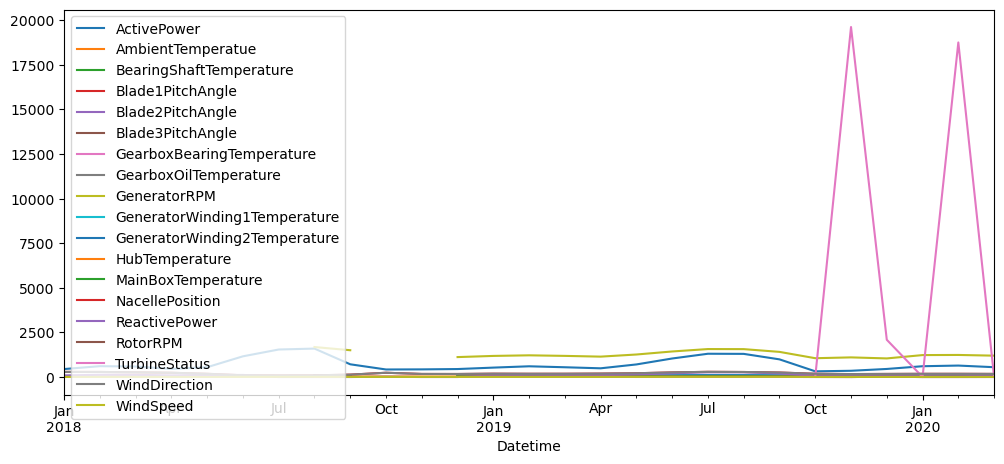

In [16]:
fig, ax = plt.subplots(figsize = (12,5))
d1.plot(ax = ax)
plt.show()

In [17]:
y1 = data["ActivePower"].resample('MS').mean() #many ways to do this
y2 = data["ActivePower"].resample('D').mean()
y3 = data["ActivePower"].resample('H').mean()
y1.head()

Datetime
2018-01-01 00:00:00+00:00    445.629683
2018-02-01 00:00:00+00:00    607.546661
2018-03-01 00:00:00+00:00    588.055022
2018-04-01 00:00:00+00:00    453.768575
2018-05-01 00:00:00+00:00    550.100070
Freq: MS, Name: ActivePower, dtype: float64

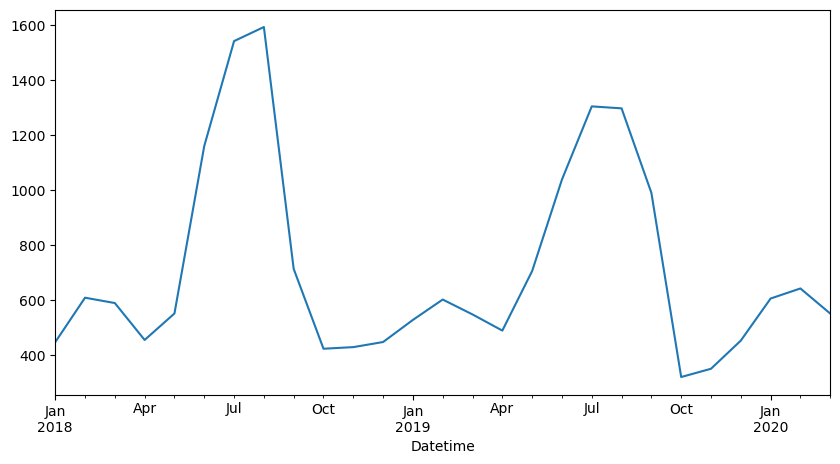

In [18]:
fig, ax = plt.subplots(figsize = (10,5))
y1.plot(ax = ax)
plt.show()

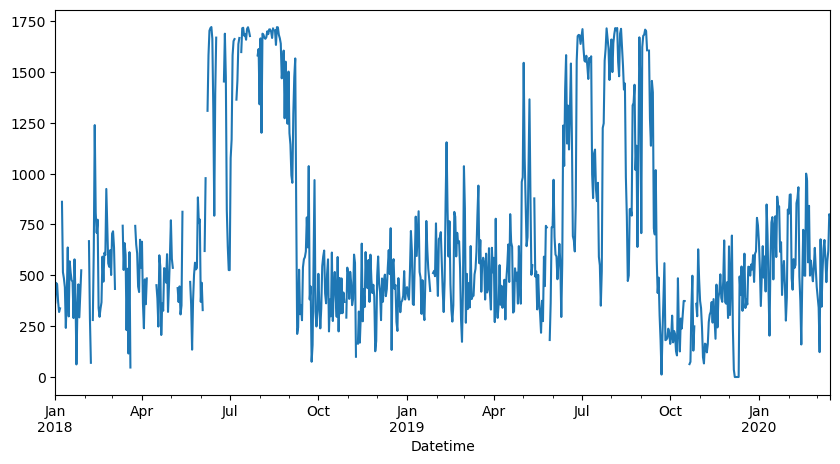

In [19]:
fig, ax = plt.subplots(figsize = (10,5))
y2.plot(ax = ax)
plt.show()

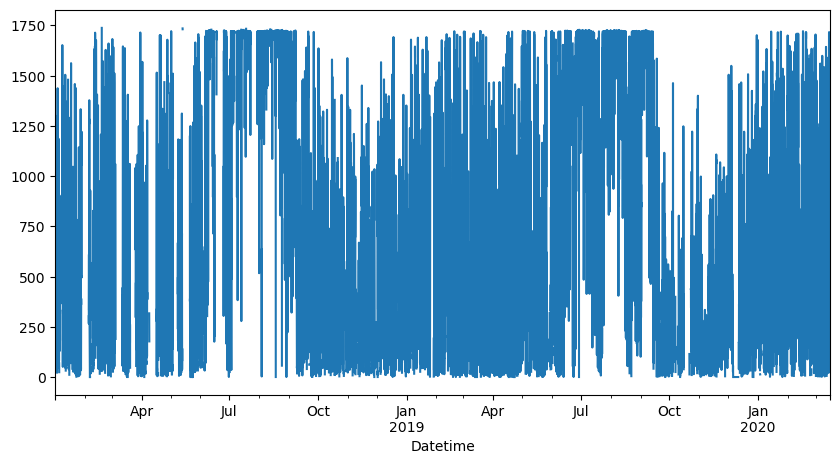

In [20]:
fig, ax = plt.subplots(figsize = (10,5))
y3.plot(ax = ax)
plt.show()

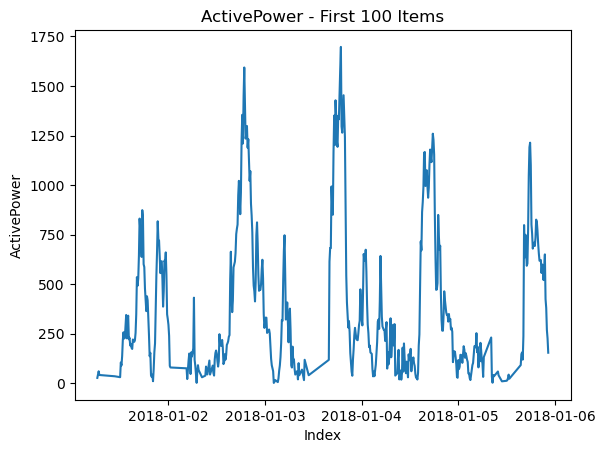

In [21]:
plt.plot(data["ActivePower"].head(500))
plt.xlabel("Index")
plt.ylabel("ActivePower")
plt.title("ActivePower - First 100 Items")
plt.show()

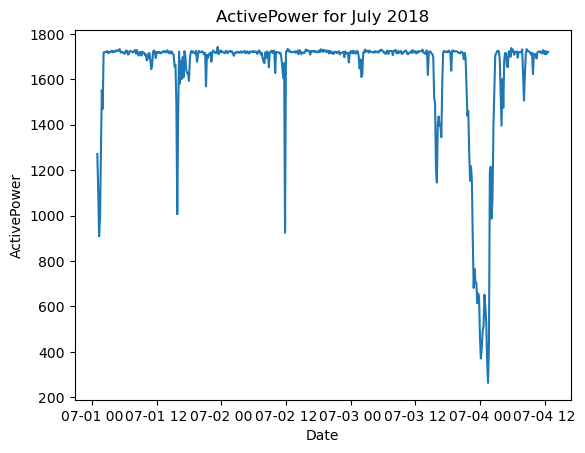

In [22]:
july_2019_data = data[(data.index.month == 7) & (data.index.year == 2019)]

# Plot the ActivePower for July 2018
plt.plot(july_2019_data["ActivePower"].head(500))
plt.xlabel("Date")
plt.ylabel("ActivePower")
plt.title("ActivePower for July 2018")
plt.show()

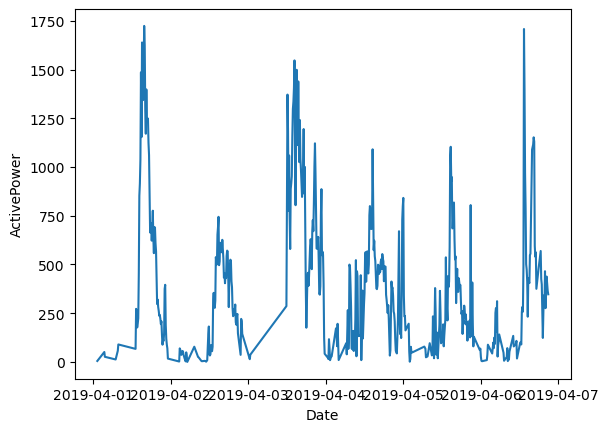

In [23]:
ap_2019_data = data[(data.index.month == 4) & (data.index.year == 2019)]

# Plot the ActivePower for July 2018
plt.plot(ap_2019_data["ActivePower"].head(500))
plt.xlabel("Date")
plt.ylabel("ActivePower")
plt.show()

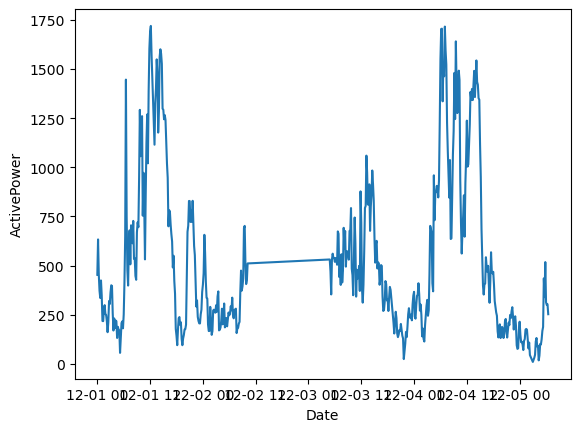

In [24]:
dec_2019_data = data[(data.index.month == 12) & (data.index.year == 2019)]

# Plot the ActivePower for July 2018
plt.plot(dec_2019_data["ActivePower"].head(500))
plt.xlabel("Date")
plt.ylabel("ActivePower")
plt.show()

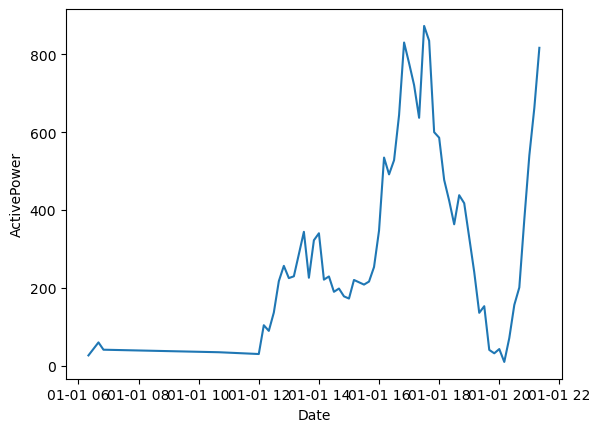

In [25]:

plt.plot(data["ActivePower"].head(60))
plt.xlabel("Date")
plt.ylabel("ActivePower")
plt.show()

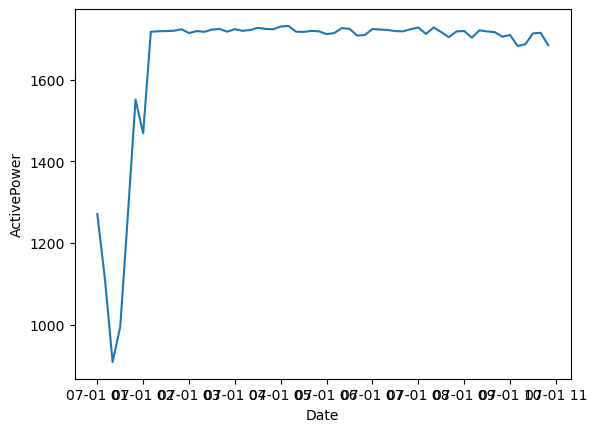

In [26]:
plt.plot(july_2019_data["ActivePower"].head(60))
plt.xlabel("Date")
plt.ylabel("ActivePower")
plt.show()

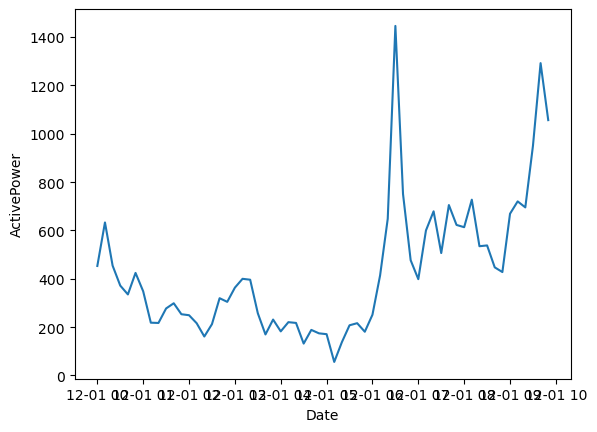

In [27]:
plt.plot(dec_2019_data["ActivePower"].head(60))
plt.xlabel("Date")
plt.ylabel("ActivePower")
plt.show()

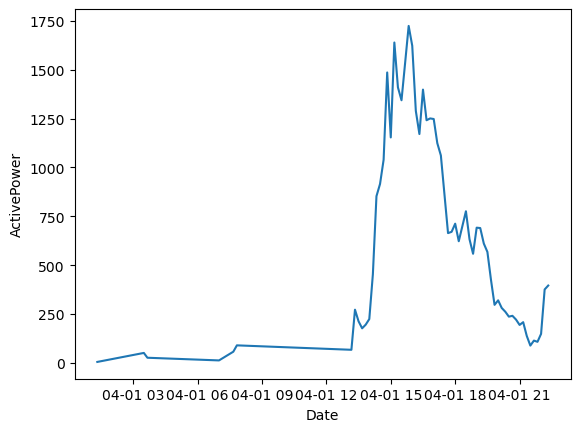

In [28]:
plt.plot(ap_2019_data["ActivePower"].head(60))
plt.xlabel("Date")
plt.ylabel("ActivePower")
plt.show()

In [29]:
selected_features = [
    'BearingShaftTemperature',
    'GearboxBearingTemperature',
    'GearboxOilTemperature',
    'GeneratorWinding2Temperature',
    'ReactivePower',
    'RotorRPM',
    'WindSpeed'
]

X = data[selected_features].copy()
X.set_index(y.index, inplace=True)
X1 = X.resample('MS').mean() #many ways to do this
X2 = X.resample('D').mean()
X3 = X.resample('H').mean()

In [30]:
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [31]:
adf_test(y)

Results of Augmented Dickey-Fuller Test:
Test Statistic                -1.522004e+01
p-value                        5.501421e-28
#Lags Used                     6.400000e+01
Number of Observations Used    7.713700e+04
Critical Value (1%)           -3.430435e+00
Critical Value (5%)           -2.861577e+00
Critical Value (10%)          -2.566790e+00
dtype: float64


In [32]:
combined_data = pd.concat([X, y], axis=1)
combined_data1 = combined_data.resample('MS').mean() #many ways to do this
combined_data2 = combined_data.resample('D').mean()
combined_data3 = combined_data.resample('H').mean()

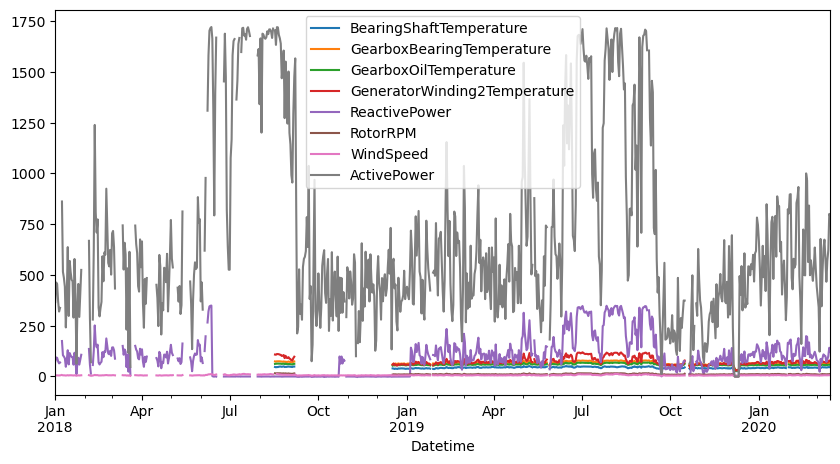

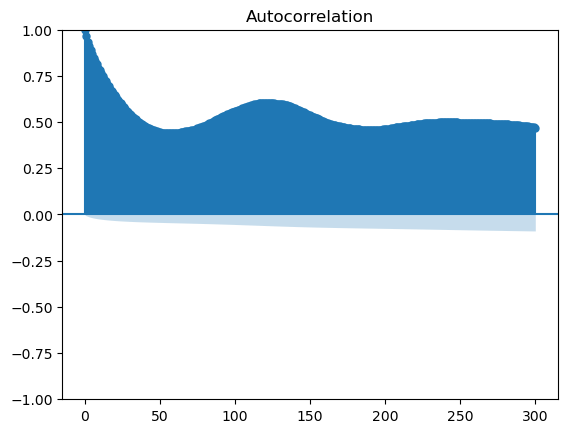

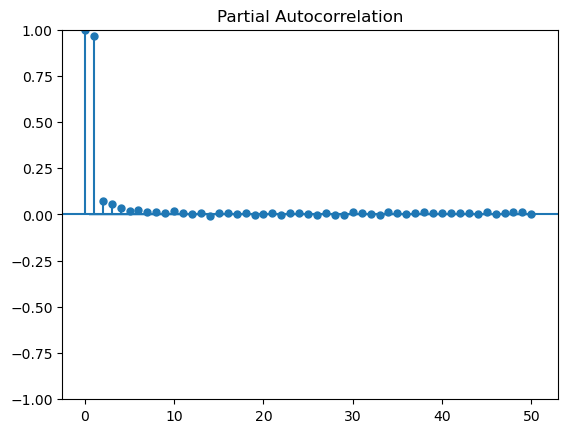

In [33]:
fig, ax = plt.subplots(figsize = (10,5))
combined_data2.plot(ax = ax)
plt.show()
plot_acf(y,lags=300) 
plot_pacf(y ,lags=50) 
plt.show()


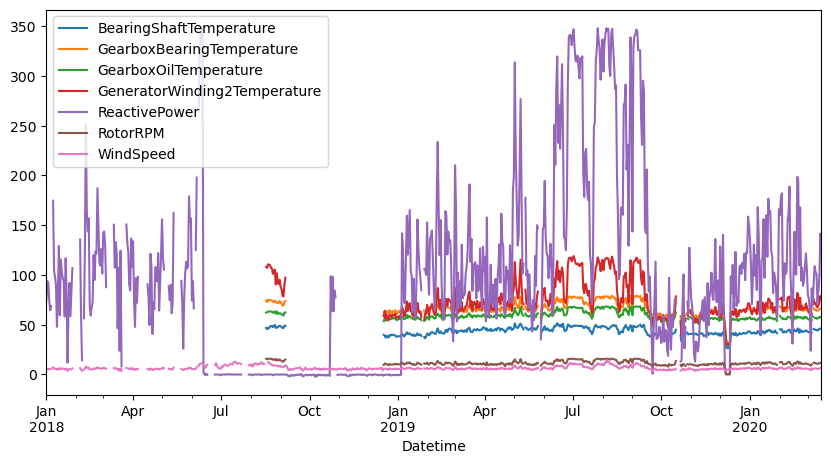

In [34]:
fig, ax = plt.subplots(figsize = (10,5))
X2.plot(ax = ax)
plt.show()

In [35]:
def diff(data, interval):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff


In [36]:
y2.shape

(805,)

In [37]:
D1=diff(y2, 15)
D1_cleaned = [x for x in D1 if x is not None]

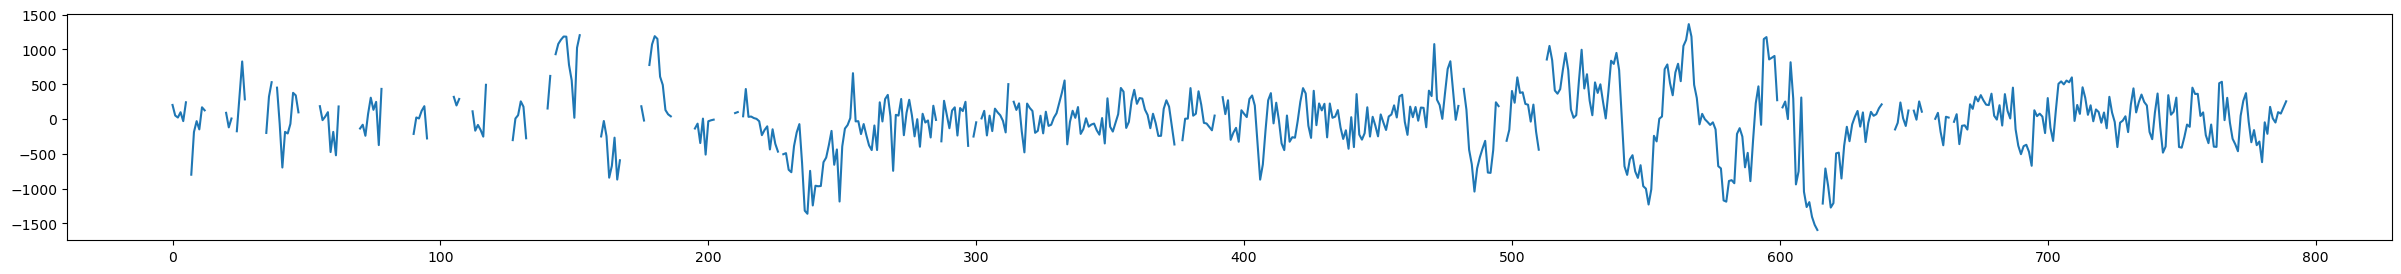

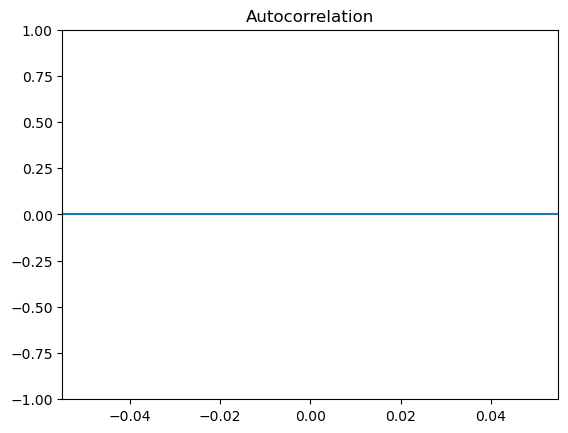

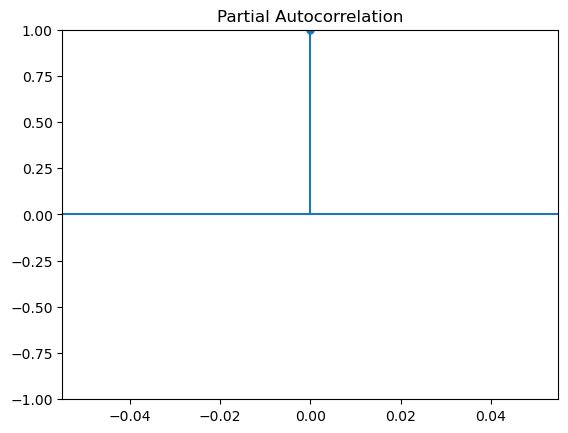

In [38]:
plt.figure(figsize=(30, 10))
plt.subplot(3,1,1)

plt.plot(D1)
plt.show()

plot_acf(D1_cleaned,lags=1)
plt.show()

plot_pacf(D1_cleaned,lags=5)
plt.show()

In [39]:
train, test = y2[0:-15], y2[-16: -1]
model=ARIMA(y2,order=(0,0,0),seasonal_order=(1,1,1,15))
model_fit = model.fit()
predictions = model_fit.forecast(15)
mae = skmetrics.mean_absolute_error(test, predictions)
mae

128.57636094696718

In [40]:
model=ARIMA(y2,order=(0,0,0),seasonal_order=(1,1,1,15))
results = model.fit()
print(results.summary())

                                SARIMAX Results                                 
Dep. Variable:              ActivePower   No. Observations:                  805
Model:             ARIMA(1, 1, [1], 15)   Log Likelihood               -5353.985
Date:                  Tue, 05 Dec 2023   AIC                          10713.970
Time:                          10:59:52   BIC                          10727.986
Sample:                      01-01-2018   HQIC                         10719.358
                           - 03-15-2020                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L15      -0.4212      0.081     -5.214      0.000      -0.580      -0.263
ma.S.L15       0.0191      0.095      0.201      0.841      -0.167       0.206
sigma2      1.615e+05   6616.653    

In [41]:
forecast = results.forecast(15)
forecast

2020-03-16 00:00:00+00:00    453.911869
2020-03-17 00:00:00+00:00    523.490566
2020-03-18 00:00:00+00:00    401.671976
2020-03-19 00:00:00+00:00    270.150023
2020-03-20 00:00:00+00:00    810.688389
2020-03-21 00:00:00+00:00    598.562530
2020-03-22 00:00:00+00:00    535.475421
2020-03-23 00:00:00+00:00    716.973777
2020-03-24 00:00:00+00:00    602.790320
2020-03-25 00:00:00+00:00    575.345222
2020-03-26 00:00:00+00:00    483.444438
2020-03-27 00:00:00+00:00    526.641614
2020-03-28 00:00:00+00:00    588.374185
2020-03-29 00:00:00+00:00    735.791087
2020-03-30 00:00:00+00:00    687.685538
Freq: D, Name: predicted_mean, dtype: float64

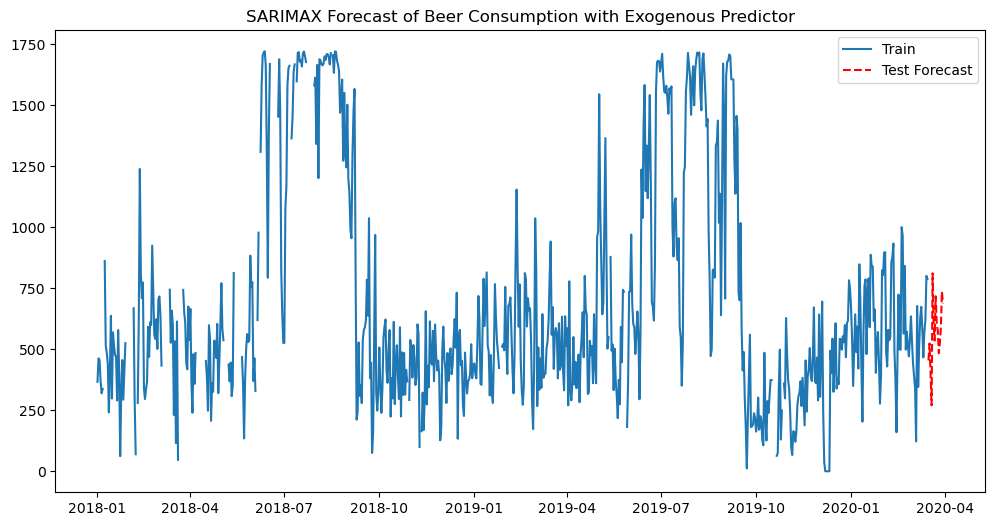

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(y2.index, y2, label='Train')
plt.plot(forecast, label='Test Forecast', color='red', linestyle='--')
plt.title('SARIMAX Forecast of Beer Consumption with Exogenous Predictor')
plt.legend()
plt.show()

In [43]:
feature_columns = ['BearingShaftTemperature', 'GearboxBearingTemperature', 'GearboxOilTemperature', 'GeneratorWinding2Temperature', 'ReactivePower', 'RotorRPM', 'WindSpeed']

order = (0, 0, 0)
forecast_steps = 15  
result = []

# Function to fill missing values with the mean of the previous and next observations
def fill_missing_with_mean(series):
    return series.fillna((series.shift(1) + series.shift(-1)) / 2)

for feature_column in feature_columns:
    time_series = X2[feature_column]
    time_series_filled = fill_missing_with_mean(time_series)
    
    model = ARIMA(time_series_filled, order=order)
    fit_model = model.fit()
    forecast_values = fit_model.forecast(steps=forecast_steps)
    result.append(forecast_values)

new_X = pd.concat(result, axis=1)
new_X.shape

(15, 7)

In [44]:
X2_filled = X2[feature_columns].apply(fill_missing_with_mean)
X2_filled = X2_filled.apply(lambda col: col.fillna(col.mean()))
X2_filled.isna().sum()

BearingShaftTemperature         0
GearboxBearingTemperature       0
GearboxOilTemperature           0
GeneratorWinding2Temperature    0
ReactivePower                   0
RotorRPM                        0
WindSpeed                       0
dtype: int64

In [45]:
model=ARIMA(endog=y2, exog=X2_filled,order=(0,0,0),seasonal_order=(1,1,1,15))
results = model.fit()
print(results.summary())

                                SARIMAX Results                                 
Dep. Variable:              ActivePower   No. Observations:                  805
Model:             ARIMA(1, 1, [1], 15)   Log Likelihood               -4291.956
Date:                  Tue, 05 Dec 2023   AIC                           8603.911
Time:                          10:59:59   BIC                           8650.632
Sample:                      01-01-2018   HQIC                          8621.870
                           - 03-15-2020                                         
Covariance Type:                    opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
BearingShaftTemperature         25.9131      2.933      8.834      0.000      20.164      31.663
GearboxBearingTemperature      -10.1944      6.111     -1.668

In [46]:
forecast = results.forecast(15,exog=new_X)
forecast = pd.DataFrame(forecast)

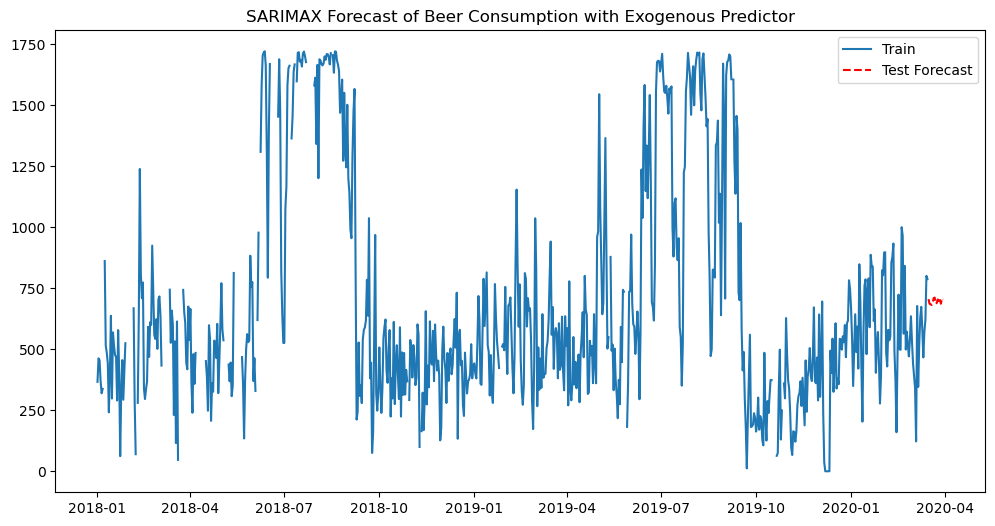

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(y2.index, y2, label='Train')
plt.plot(forecast, label='Test Forecast', color='red', linestyle='--')
plt.title('SARIMAX Forecast of Beer Consumption with Exogenous Predictor')
plt.legend()
plt.show()

In [48]:
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [49]:
combined_data2

BearingShaftTemperature  GearboxBearingTemperature  \
Datetime                                                                        
2018-01-01 00:00:00+00:00                      NaN                        NaN   
2018-01-02 00:00:00+00:00                      NaN                        NaN   
2018-01-03 00:00:00+00:00                      NaN                        NaN   
2018-01-04 00:00:00+00:00                      NaN                        NaN   
2018-01-05 00:00:00+00:00                      NaN                        NaN   
...                                            ...                        ...   
2020-03-11 00:00:00+00:00                44.059155                  64.106761   
2020-03-12 00:00:00+00:00                44.476550                  64.051326   
2020-03-13 00:00:00+00:00                45.903233                  65.348205   
2020-03-14 00:00:00+00:00                45.924987                  65.975734   
2020-03-15 00:00:00+00:00                45.640587                  66.482961   

                           GearboxOilTemperature  \
Datetime                                           
2018-01-01 00:00:00+00:00                    NaN   
2018-01-02 00:00:00+00:00                    NaN   
2018-01-03 00:00:00+00:00                    NaN   
2018-01-04 00:00:00+00:00                    NaN   
2018-01-05 00:00:00+00:00                    NaN   
...                                          ...   
2020-03-11 00:00:00+00:00              56.921031   
2020-03-12 00:00:00+00:00              56.194520   
2020-03-13 00:00:00+00:00              57.663415   
2020-03-14 00:00:00+00:00              57.703463   
2020-03-15 00:00:00+00:00              57.333608   

                           GeneratorWinding2Temperature  ReactivePower  \
Datetime                                                                 
2018-01-01 00:00:00+00:00                           NaN      74.042120   
2018-01-02 00:00:00+00:00                           NaN      93.555723   
2018-01-03 00:00:00+00:00                           NaN      91.627843   
2018-01-04 00:00:00+00:00                           NaN      74.360621   
2018-01-05 00:00:00+00:00                           NaN      64.366148   
...                                                 ...            ...   
2020-03-11 00:00:00+00:00                     67.174603      71.852813   
2020-03-12 00:00:00+00:00                     69.288543      84.040654   
2020-03-13 00:00:00+00:00                     72.096953      99.693231   
2020-03-14 00:00:00+00:00                     78.702074     141.418250   
2020-03-15 00:00:00+00:00                     76.298839     121.420402   

                            RotorRPM  WindSpeed  ActivePower  
Datetime                                                      
2018-01-01 00:00:00+00:00        NaN   5.263797   366.223561  
2018-01-02 00:00:00+00:00        NaN   5.390719   462.550740  
2018-01-03 00:00:00+00:00        NaN   5.295225   454.417752  
2018-01-04 00:00:00+00:00        NaN   5.094994   369.952190  
2018-01-05 00:00:00+00:00        NaN   4.915224   319.446595  
...                              ...        ...          ...  
2020-03-11 00:00:00+00:00  10.420975   5.385570   466.289248  
2020-03-12 00:00:00+00:00  10.931663   5.693483   570.315539  
2020-03-13 00:00:00+00:00  10.884414   5.765318   619.637333  
2020-03-14 00:00:00+00:00  11.506644   6.217917   800.312824  
2020-03-15 00:00:00+00:00  11.870329   6.458906   787.305117  

[805 rows x 8 columns]

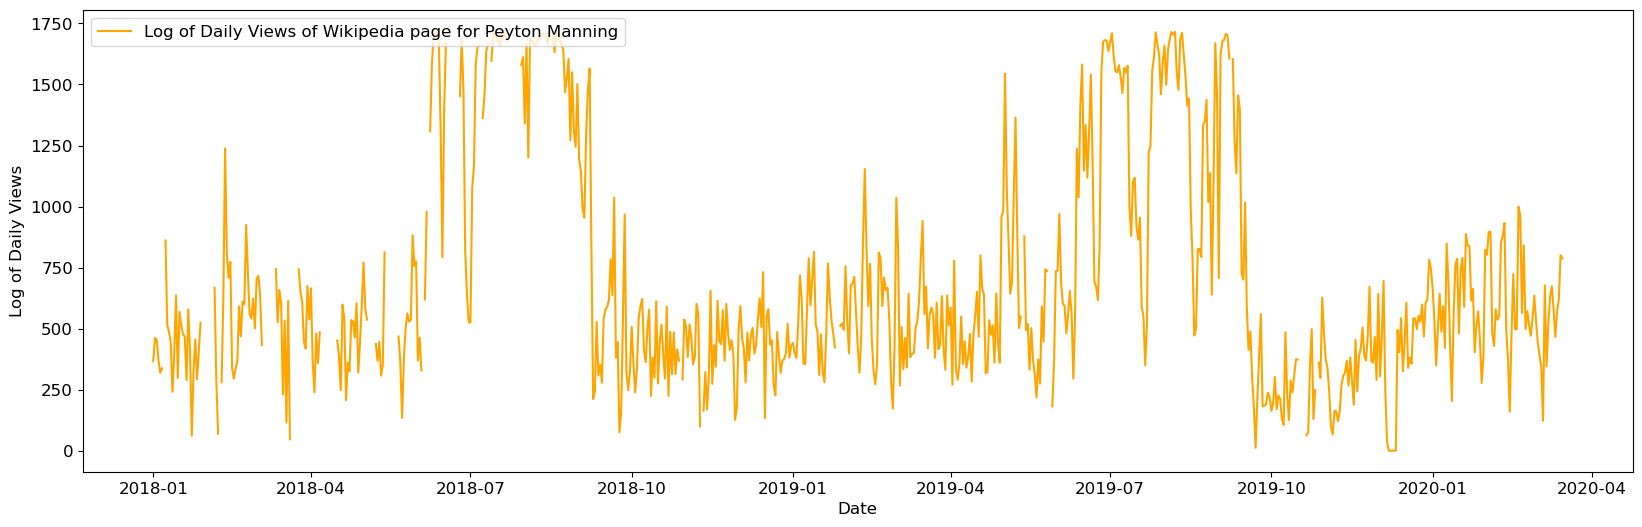

In [50]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(combined_data2.index, combined_data2.ActivePower, color='orange', label='Log of Daily Views of Wikipedia page for Peyton Manning')
ax.set_xlabel('Date')
ax.set_ylabel('Log of Daily Views')
ax.legend(loc='upper left')

In [51]:
combined_data2.rename(columns = {'Datetime':'ds', 'ActivePower':'y'}, inplace = True)
combined_data2.index.name = 'ds'
combined_data2.reset_index(inplace=True)
combined_data2['ds'] = pd.to_datetime(combined_data2['ds'])
combined_data2

ds  BearingShaftTemperature  \
0   2018-01-01 00:00:00+00:00                      NaN   
1   2018-01-02 00:00:00+00:00                      NaN   
2   2018-01-03 00:00:00+00:00                      NaN   
3   2018-01-04 00:00:00+00:00                      NaN   
4   2018-01-05 00:00:00+00:00                      NaN   
..                        ...                      ...   
800 2020-03-11 00:00:00+00:00                44.059155   
801 2020-03-12 00:00:00+00:00                44.476550   
802 2020-03-13 00:00:00+00:00                45.903233   
803 2020-03-14 00:00:00+00:00                45.924987   
804 2020-03-15 00:00:00+00:00                45.640587   

     GearboxBearingTemperature  GearboxOilTemperature  \
0                          NaN                    NaN   
1                          NaN                    NaN   
2                          NaN                    NaN   
3                          NaN                    NaN   
4                          NaN                    NaN   
..                         ...                    ...   
800                  64.106761              56.921031   
801                  64.051326              56.194520   
802                  65.348205              57.663415   
803                  65.975734              57.703463   
804                  66.482961              57.333608   

     GeneratorWinding2Temperature  ReactivePower   RotorRPM  WindSpeed  \
0                             NaN      74.042120        NaN   5.263797   
1                             NaN      93.555723        NaN   5.390719   
2                             NaN      91.627843        NaN   5.295225   
3                             NaN      74.360621        NaN   5.094994   
4                             NaN      64.366148        NaN   4.915224   
..                            ...            ...        ...        ...   
800                     67.174603      71.852813  10.420975   5.385570   
801                     69.288543      84.040654  10.931663   5.693483   
802                     72.096953      99.693231  10.884414   5.765318   
803                     78.702074     141.418250  11.506644   6.217917   
804                     76.298839     121.420402  11.870329   6.458906   

              y  
0    366.223561  
1    462.550740  
2    454.417752  
3    369.952190  
4    319.446595  
..          ...  
800  466.289248  
801  570.315539  
802  619.637333  
803  800.312824  
804  787.305117  

[805 rows x 9 columns]

In [52]:
combined_data2['ds'] = combined_data2['ds'].dt.tz_localize(None)


In [53]:
#Prophet project
m = Prophet() #default trend= piece-wise linear models
              # default include weekly and yearly seasonalities 

#Fit with default settings
print(combined_data2.columns)
m.fit(combined_data2)
#Dataframe with forecasting steps
future = m.make_future_dataframe(periods=15)
print(future)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

10:59:59 - cmdstanpy - INFO - Chain [1] start processing
10:59:59 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'BearingShaftTemperature', 'GearboxBearingTemperature',
       'GearboxOilTemperature', 'GeneratorWinding2Temperature',
       'ReactivePower', 'RotorRPM', 'WindSpeed', 'y'],
      dtype='object')
            ds
0   2018-01-01
1   2018-01-02
2   2018-01-03
3   2018-01-04
4   2018-01-05
..         ...
815 2020-03-26
816 2020-03-27
817 2020-03-28
818 2020-03-29
819 2020-03-30

[820 rows x 1 columns]


ds        yhat  yhat_lower  yhat_upper
815 2020-03-26  539.445434  230.993047  902.654824
816 2020-03-27  477.647966  156.021254  821.752362
817 2020-03-28  475.672927  132.070822  802.535657
818 2020-03-29  451.991090  124.982818  795.631159
819 2020-03-30  452.404624  135.595919  759.669132

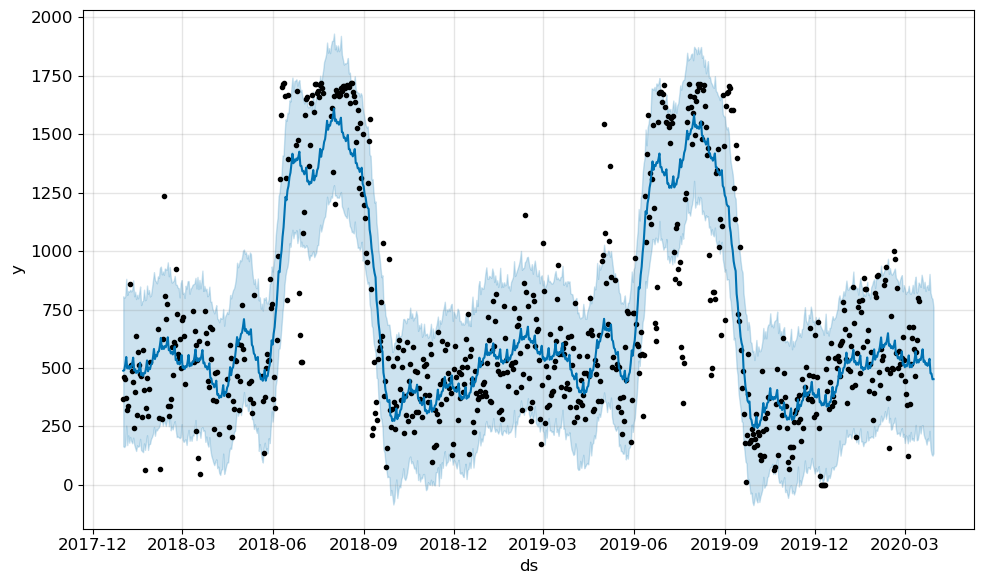

In [54]:
fig1 = m.plot(forecast)

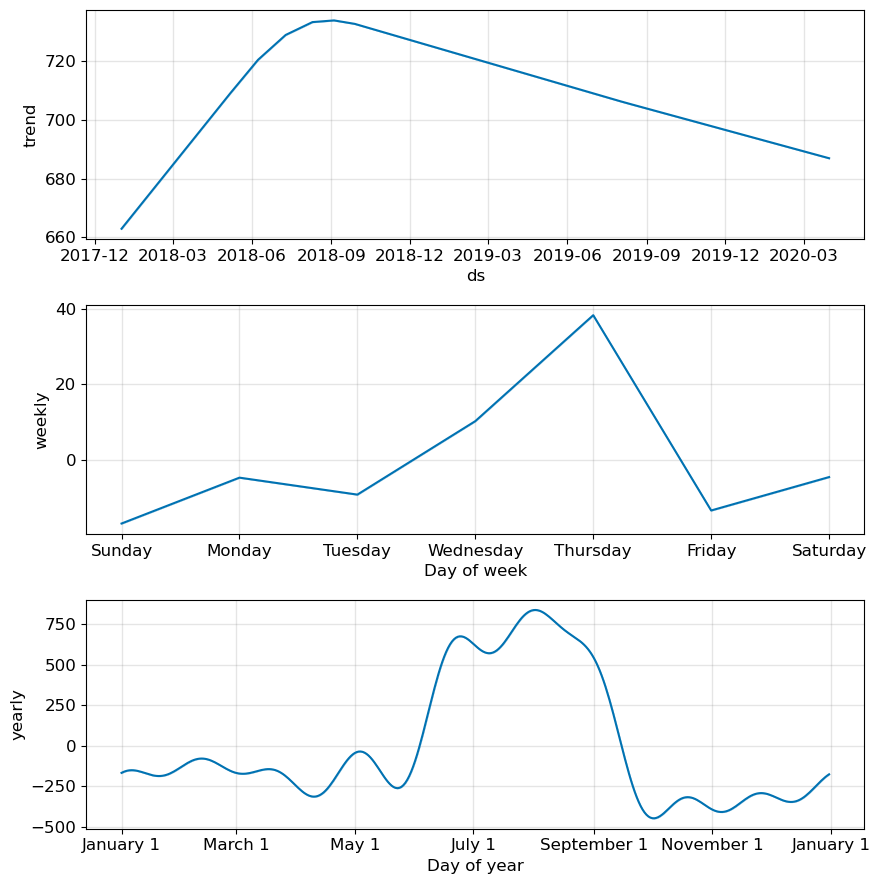

In [55]:
fig2 = m.plot_components(forecast)

In [56]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [57]:
plot_components_plotly(m, forecast)

In [58]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel

model = ExponentialSmoothing(y2[-30:], trend="add", seasonal="add", seasonal_periods=15, damped_trend=False).fit()

In [59]:
pred = pd.DataFrame(model.forecast(15))
pred 

0
2020-03-16 00:00:00+00:00  549.896578
2020-03-17 00:00:00+00:00  646.763913
2020-03-18 00:00:00+00:00  507.897177
2020-03-19 00:00:00+00:00  397.592879
2020-03-20 00:00:00+00:00  926.612468
2020-03-21 00:00:00+00:00  747.593141
2020-03-22 00:00:00+00:00  634.747820
2020-03-23 00:00:00+00:00  836.712509
2020-03-24 00:00:00+00:00  696.464675
2020-03-25 00:00:00+00:00  693.706677
2020-03-26 00:00:00+00:00  615.209529
2020-03-27 00:00:00+00:00  651.506929
2020-03-28 00:00:00+00:00  715.992138
2020-03-29 00:00:00+00:00  856.241475
2020-03-30 00:00:00+00:00  798.768117

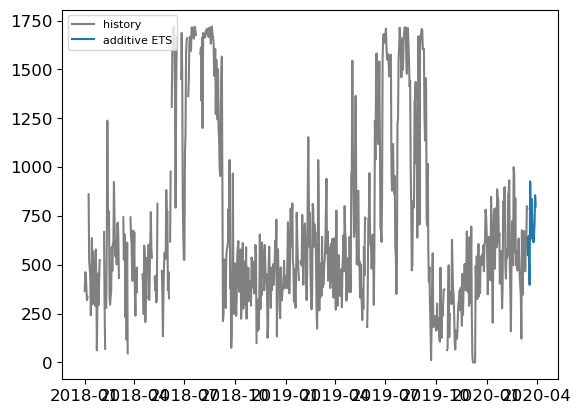

In [60]:
plt.plot(y2, label='history', color='grey')

plt.plot(pred, label='additive ETS')

plt.legend(loc='upper left', fontsize=8)
plt.show()

In [61]:
model = ThetaModel(y2[-30:])
res = model.fit()
pred = res.forecast(len(test))

In [62]:
pred = pd.DataFrame(pred.values, index=pred.index)

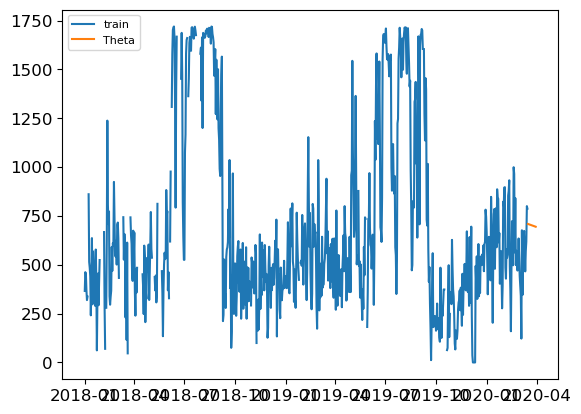

In [63]:
plt.plot(y2, label='train')
plt.plot(pred, label='Theta')
plt.legend(loc='upper left', fontsize=8)
plt.show()